# Notebook to develop HMM model to investigate optimal angle selection

## Defining the targets we will be using in our multiaspect classification model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

from scipy.special import spherical_jn, spherical_yn

import ipywidgets as widgets
from IPython.display import display

## Below is the analytical DWBA solution for a prolate spheroid geometry

In [2]:
def dwba_prolate_spheroid(L, a, g, h, ka, phi):
    """
    DWBA solution for a fluid prolate spheroid.
    Lee, W.-J., Lavery, A. C., and Stanton, T. K. (2012). 
    “Orientation dependence of broadband acoustic backscattering from live squid,” 
    The Journal of the Acoustical Society of America, 131, 4461–4475. doi:10.1121/1.3701876
    
    Parameters
    ----------
    L : float
        Length of spheroid (long axis) [m]
    a : float
        Radius of spheroid (short axis) [m]
    g : float
        Density contrast (rho2/rho1)
    h : float
        Sound speed contrast (c2/c1)
    ka : array_like
        Dimensionless ka (wavenumber * radius)
    phi : float or array_like
        Incident angle [radians]

    Returns
    -------
    fbs : array_like
        Complex backscattering amplitude
    """
    # Convert inputs to arrays and ensure proper broadcasting
    ka = np.atleast_1d(ka)
    phi = np.atleast_1d(phi)

    # Calculate contrast term
    contrast = 1/(g * h**2) + 1/g - 2
    
    # Convert incident angle to beta
    beta = phi[..., np.newaxis] + np.pi / 2  # Add dimension for broadcasting with ka
    # beta = phi + np.pi/2
    
    # Calculate aspect ratio term (L/2a)
    aspect_ratio = L / (2 * a)

    # Calculate argument for Bessel function
    ellip_term = np.sqrt(np.sin(beta)**2 + (aspect_ratio**2) * np.cos(beta)**2)
    bessel_arg = 2 * ka / h * ellip_term
    
    # Calculate spherical Bessel function
    j1 = spherical_jn(1, bessel_arg)
    
    # Calculate final backscattering amplitude
    fbs = (ka**2) * L * contrast/2 * j1/bessel_arg

    return fbs.squeeze()

## Defining the measurement and target constants

In [3]:
a = 0.15 # semi-minor axis (equatorial radius)
g = 1.043 # density contrast
h = 1.053 # sound speed contrast
c = 1500 # speed of sound in water

freq_lowerbound = 100 # frequency response lower bound
freq_upperbound = 30e3 # frequency response upper bound
freq = np.arange(freq_lowerbound, freq_upperbound, 10)
k = 2*np.pi*freq / c # acoustic wavenumber (phase shift per meter)
ka = k*a

angle_step = 0.5
angle_all = np.arange(-90, 90, angle_step)

## Below is code borrowed from the [BOAT fundamentals repository](https://boat-fundamentals.readthedocs.io/en/latest/acoustics/TS_03_discrete.html#orientation-dependency)

It has been modified to include an aspect ratio parameter so we can see the 2 targets we need using the slider: a sphere (AR = 1) and spheroid (AR > 1)

In [4]:
def plot_dwba_for_prolate_spheroid(angle, aspect_ratio):
    L = aspect_ratio*2*a

    # TS across all angles
    phi_all = np.deg2rad(angle_all)
    fbs_full = dwba_prolate_spheroid(L, a, g, h, ka, phi_all)
    TS_all = 20*np.log10(np.abs(fbs_full))

    phi = np.deg2rad(angle)
    fbs = dwba_prolate_spheroid(L, a, g, h, ka, phi)
    TS = 20*np.log10(np.abs(fbs))

    # Define ellipse parameters
    width = 2*a  # width
    height = L  # height
    ellipse_angle = 90-angle  # rotation angle [deg]

    # Create the ellipse patch
    ellipse = patches.Ellipse(
        (0.5, 0.5), width, height, angle=ellipse_angle, 
        facecolor='lightblue', edgecolor='blue')

    fig = plt.figure(figsize=(7,6))
    gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1])
    fig.subplots_adjust(hspace=0.1)

    # All angles
    ax0 = fig.add_subplot(gs[0,0])
    ax0.imshow(TS_all, aspect="auto", vmax=-25, vmin=-80,
                extent=(0, freq_upperbound//1e3, 90, -90))
    ax0.set_yticks(np.arange(-90, 91, 30))
    ax0.set_ylabel("Incident angle (°)", fontsize=12)
    ax0.set_xlim(freq_lowerbound, freq_upperbound)
    ax0.axhline(angle, color="magenta")

    # One angle slice
    ax1 = fig.add_subplot(gs[1,0], sharex=ax0)
    ax1.plot(freq/1e3, TS, lw=0.75)
    ax1.set_xlim(freq_lowerbound/1e3, freq_upperbound/1e3)
    ax1.set_ylim(-90, -20)
    ax1.set_xlabel("Frequency (kHz)", fontsize=12)
    ax1.set_ylabel("TS (dB)", fontsize=12)

    # Ellipse (cross section of prolate spheroid)
    ax_ellip = fig.add_subplot(gs[1,1])
    ax_ellip.add_patch(ellipse)
    ax_ellip.annotate("Incident sound", xytext=(0.5, 1.2), xy=(0.5, 0.95),
        arrowprops=dict(arrowstyle="->,head_length=0.5,head_width=0.3",
                        linewidth=2),
        fontsize=12,
        ha="center")
    ax_ellip.set_aspect('equal', adjustable='box')
    ax_ellip.axis('off')
    ax_ellip.set_xlim(0, 1)
    ax_ellip.set_ylim(0, 1.2)

    ax0.set_title("TS of a fluid prolate spheroid")
    plt.tight_layout()
    plt.show()

    return TS_all

## Below I have attached two visualizations but both are using the same function

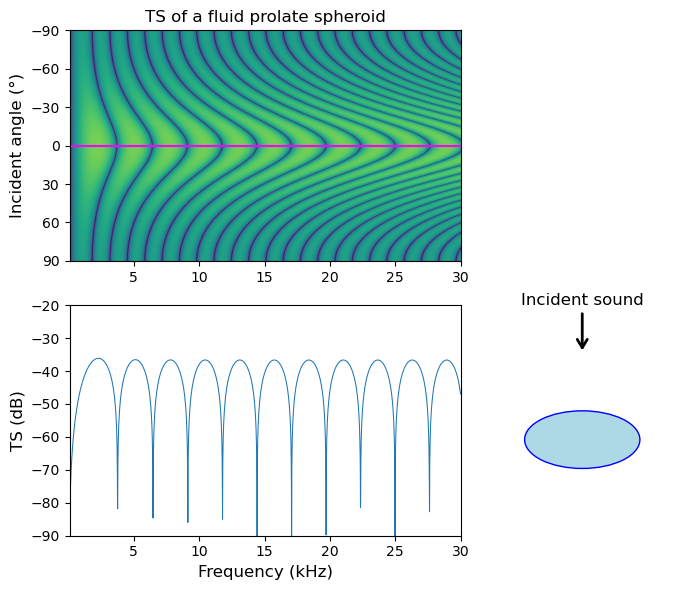

In [5]:
prolate_spheroid_AR = 2
TS_all_prolate_spheroid = plot_dwba_for_prolate_spheroid(angle=0, aspect_ratio=prolate_spheroid_AR)

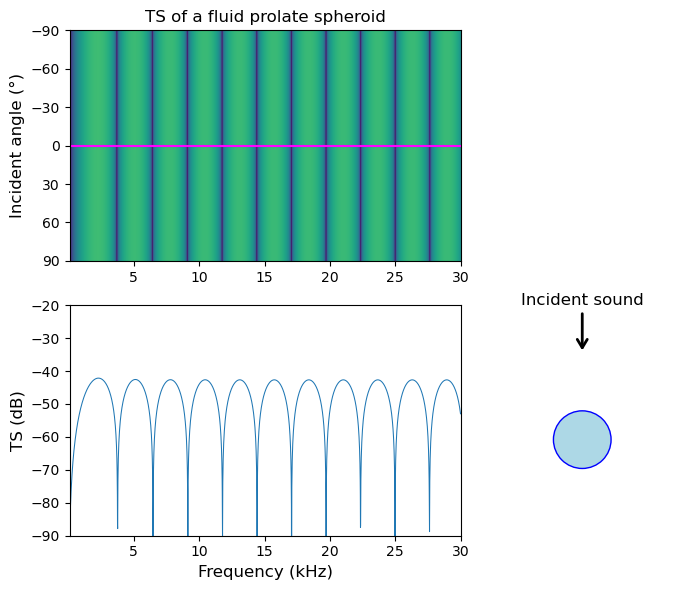

In [6]:
sphere_AR = 1
TS_all_sphere = plot_dwba_for_prolate_spheroid(angle=0, aspect_ratio=sphere_AR)

## Extract the acoustic color from the above functions and plot them side-by-side below

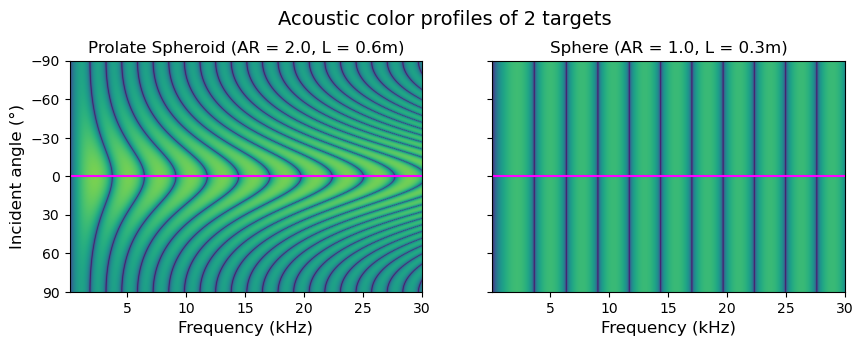

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10,3), sharey=True)
plt.rcParams.update({'font.size':10})
fig.subplots_adjust(hspace=0.1)
fig.suptitle('Acoustic color profiles of 2 targets', y=1.05, fontsize=plt.rcParams['font.size']+4)

ax0 = ax[0]
ax0.set_title(f'Prolate Spheroid (AR = 2.0, L = {prolate_spheroid_AR*2*a}m)')
ax0.imshow(TS_all_prolate_spheroid , aspect="auto", vmax=-25, vmin=-80,
            extent=(0, freq_upperbound//1e3, 90, -90))
ax0.set_yticks(np.arange(-90, 91, 30))
ax0.set_ylabel("Incident angle (°)", fontsize=12)
ax0.axhline(0, color="magenta")
ax0.set_xlim(freq_lowerbound/1e3, freq_upperbound/1e3)
ax0.set_xlabel("Frequency (kHz)", fontsize=12)

ax1 = ax[1]
ax1.set_title(f'Sphere (AR = 1.0, L = {sphere_AR*2*a}m)')
ax1.imshow(TS_all_sphere , aspect="auto", vmax=-25, vmin=-80,
            extent=(0, freq_upperbound//1e3, 90, -90))
ax1.set_yticks(np.arange(-90, 91, 30))
ax1.axhline(0, color="magenta")
ax1.set_xlim(freq_lowerbound/1e3, freq_upperbound/1e3)
ax1.set_xlabel("Frequency (kHz)", fontsize=12)

plt.show()

In [12]:
def sample_angle_and_compare_response(angle):
    angle_idx = np.where(angle_all==angle)[0][0]
    TS_prolate_spheroid = TS_all_prolate_spheroid[angle_idx,:]
    TS_sphere = TS_all_sphere[angle_idx,:]

    fig, ax = plt.subplots(1, 1, figsize=(5,3))
    ax.plot(freq/1e3, TS_prolate_spheroid, lw=0.75)
    ax.plot(freq/1e3, TS_sphere, lw=0.75)
    ax.set_xlim(freq_lowerbound/1e3, freq_upperbound/1e3)
    ax.set_ylim(-90, -20)
    ax.grid(which='both')
    ax.set_xlabel("Frequency (kHz)", fontsize=12)
    ax.set_ylabel("TS (dB)", fontsize=12)


In [16]:
angle_step = 5

In [17]:
aa = np.arange(-90, 90, angle_step)
angle_slider = widgets.SelectionSlider(
    options=aa,
    value=0,  # default value
    description="Incident angle (°)",
    style={'description_width': 'initial'},
    continuous_update=True,
    layout=widgets.Layout(width="400px"),
)

interactive_plot = widgets.interactive(
    sample_angle_and_compare_response, angle=angle_slider)
display(interactive_plot)


interactive(children=(SelectionSlider(description='Incident angle (°)', index=18, layout=Layout(width='400px')…

In [ ]:
A =